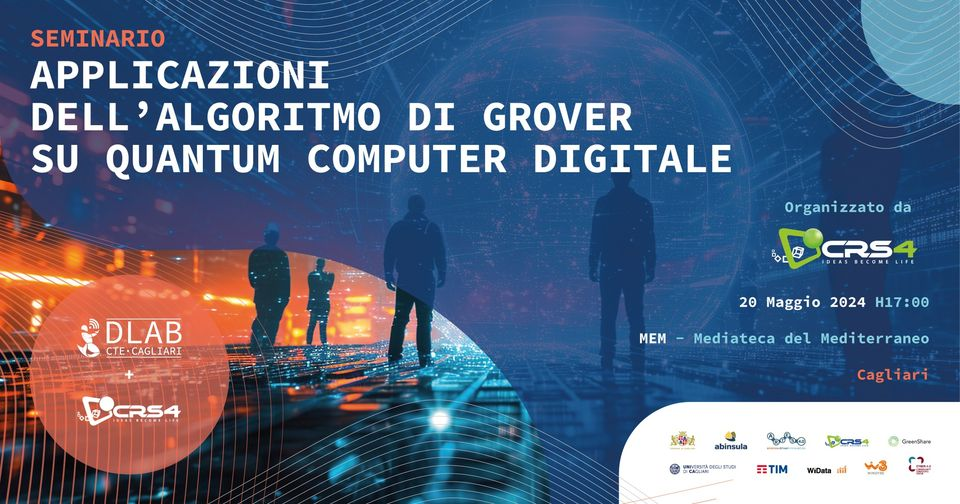


## Crediti

Questo materiale didattico è stato preparato dalle ricercatrici Manuela Profir e Giuliana Siddi Moreau del CRS4 nell'ambito del progetto DLAB-Cagliari Digital Lab (Casa delle Tecnologie Emergenti) finanziato dal MIMIT.

I contenuti del notebook si basano delle seguenti fonti:
* il materiale didattico dei corsi dell'Associazione [Qworld](https://qworld.net/), la cui opera di libera diffusione della conoscenza è formidabile. Consigliamo in particolare la frequenza dei corsi QBronze e QNickel.
* l'articolo [A Grover Search-based Algorithm for the List Coloring Problem ](https://arxiv.org/pdf/2108.09061) di Sayan Mukherjee e il suo codice presente nella [repository](https://github.com/potla1995/grover-listcoloring)
* il materiale messo a disposizione da [QPerfect](https://qperfect.io/) che ha fornito l'accesso di prova ai suoi simulatori per l'esercitazione. Per l'accesso di prova occorre, al prompt di connessione che appare sul browser, digitare le seguenti credenziali dell'utente temporaneo: (user: test1@crs4.it password: 
9r2WPIYRH ) 


In [1]:
!pip install --quiet "mimiqcircuits @ git+https://github.com/qperfect-io/mimiqcircuits-python.git"
!pip install --quiet networkx
!pip install --quiet osmnx  geopandas shapely utm

Esaminiamo prima un problema di "graph coloring". 

Possiamo pensare, ad esempio, a un problema di assegnazione di frequenze in modo che le trasmissioni da punti vicini non interferiscano tra loro.Nella città di Cagliari ad esempio potremmo avere una serie di stazioni radio (prendiamone 3 per semplicità, e dobbiamo allocare per ciascuna una diversa banda di frequenze. 

Un problema di scheduling ha la stessa formulazione, dobbiamo scegliere come fare in sequenza i passaggi di vigilanza in tre punti caldi di Cagliari.
Ovviamente per tre punti e tre opzioni (abbinate a tre colori diversi) la soluzione si trova anche a occhio. La potenza dell'algoritmo di Grover sta nel fatto che, se si scrive debitamente l'oracolo, possiamo isolare tutte le soluzioni che soddisfano i vincoli del problema.

Ovviamente per 3 punti le soluzioni che corrispondono alle combinazioni senza ripetizione si possono trovare facilmente a occhio. La potenza dell'algoritmo di Grover sta nel trovare velocemente la soluzione in situazioni molto più complicate.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mimiqcircuits import *
import networkx as nx
import os
import re

#Creiamo la connessione al simulatore QPerfect, che abbiamo a disposizione per questa esercitazione
conn= MimiqConnection(url="https://mimiq.qperfect.io/api")
#conn.loadtoken()
conn.connect()

Connection:
├── url: https://mimiq.qperfect.io/api
├── Computing time: 52/12000 minutes
├── Max time limit per request: 180 minutes
├── Default time limit is equal to max time limit: 180 minutes
└── status: open

In [3]:
vertices = [0, 1, 2]
edges = [[0,1], [1,2], [0,2]]

Definiamo l'oracolo come nell'articolo [A Grover Search-based Algorithm for the 
List Coloring Problem ](https://arxiv.org/pdf/2108.09061) di Sayan Mukherjee Dobbiamo creare una base ortonormale per i tre colori, utilizzando per ogni nodo del grafo due qubit a disposizione per descrivere le opzioni di colori. Lo facciamo attraverso l'unitaria E3 e attraverso l'unitaria complessa coniugata E3dagger. Ovviamente, se il numero di colori fosse diverso, le unitarie E3 e E3_dagger sarebbero scritte diversamente.


In [4]:
# Initialization Operators

def apply_E3( targets):
    # Applies an E3 gate on two qubits.
    assert len(targets) == 2, 'E3 only acts on 2 qubits.'
    circuit=Circuit()
    circuit.push(GateRY(1.9106332362490186),targets[0])
    circuit.push(GateRZ(1.5707963267948966),targets[1])
    circuit.push(GateH(),targets[1])
    circuit.push(GateRZ(0.7853981633974483),targets[1])
    circuit.push(GateCX(),targets[0], targets[1])
    circuit.push(GateRZ(-0.7853981633974483),targets[1])
    circuit.push(GateH(),targets[1])
    circuit.push(GateRZ(-1.5707963267948966),targets[1])
    circuit.push(GateX(),targets[0])
    return circuit

def apply_E3_dagger( targets):
    # Applies an E3_dagger on two qubits.
    assert len(targets) == 2, 'E3 only acts on 2 qubits.'
    circuit=Circuit()
    circuit.push(GateX(),targets[0])
    circuit.push(GateRZ(1.5707963267948966),targets[1])
    circuit.push(GateH(),targets[1])
    circuit.push(GateRZ(0.7853981633974483),targets[1])
    circuit.push(GateCX(),targets[0], targets[1])
    circuit.push(GateRZ(-0.7853981633974483),targets[1])
    circuit.push(GateH(),targets[1])
    circuit.push(GateRZ(-1.5707963267948966),targets[1])
    circuit.push(GateRY(-1.9106332362490186),targets[0])
    return circuit
   

In [5]:
# Implementazione dei gate di Toffoli and CCCX, ruotati secondo il riferimento per i colori
def apply_ccx(control0, control1, target):
    # circuit.ccx[control0, control1, target]
    circuit=Circuit()
    circuit.push(GateH(),target)
    circuit.push(GateCX(),control1, target)
    circuit.push(GateRZ(-0.7853981633974483),target)
    circuit.push(GateCX(),control0, target)
    circuit.push(GateRZ(0.7853981633974483),target)
    circuit.push(GateCX(),control1, target)
    circuit.push(GateRZ(-0.7853981633974483),target)
    circuit.push(GateCX(),control0, target)
    circuit.push(GateRZ(0.7853981633974483), target)
    circuit.push(GateH(),target)
    circuit.push(GateRZ(-0.7853981633974483),control1)
    circuit.push(GateCX(),control0, control1)
    circuit.push(GateRZ(-0.7853981633974483),control1)
    circuit.push(GateCX(),control0, control1)
    circuit.push(GateRZ(0.7853981633974483),control0)
    circuit.push(GateRZ(1.5707963267948966),control1)
    return circuit
    

def apply_cccx(controls, target, ancilla):
    circuit=Circuit()
    # Applies a CCCX gate onto the circuit. Requires a clean ancilla qubit.
    assert len(controls) == 3, '3 controls were not provided: CCCX gate needs a list of controls of size 3.'
    circuit.append(apply_ccx( controls[0], controls[1], ancilla))
    circuit.append(apply_ccx( controls[2], ancilla, target))
    circuit.append(apply_ccx( controls[0], controls[1], ancilla))
    return circuit

Vediamo come appare il circuto della unitaria E3

In [6]:
c_E3=apply_E3([0,1])
c_E3.draw()

        ┌──────────────────────┐                                                                                        
 q[0]: ╶┤RY(1.9106332362490186)├────────────────────────────────────────────────────●──────────────────────────────────╴
        └──────────────────────┘┌──────────────────────┐┌─┐┌──────────────────────┐┌┴┐┌───────────────────────┐┌─┐      
 q[1]: ╶────────────────────────┤RZ(1.5707963267948966)├┤H├┤RZ(0.7853981633974483)├┤X├┤RZ(-0.7853981633974483)├┤H├─────╴
                                └──────────────────────┘└─┘└──────────────────────┘└─┘└───────────────────────┘└─┘      
                                                                                                                        
...
                                 ┌─┐                                                                                    
 q[0]: ╶─────────────────────────┤X├───────────────────────────────────────────────────────────────────────────────────╴
        ┌───────────────────

In [7]:
def apply_diffusion(circuit, vertex_qubits, clean_ancilla):
    assert len(vertex_qubits) == 6, 'Only implemented for 3 vertices and 6 qubits!'
    circuit=Circuit()
    for i in range(int(len(vertex_qubits)/2)):
        circuit.append(apply_E3_dagger( [vertex_qubits[2*i], vertex_qubits[2*i+1]]))
    
    # Put in anticontrolled toffoli
    circuit.push(GateX(),[vertex_qubits[0],vertex_qubits[1],vertex_qubits[2]])
    
    circuit.push(GateX(),vertex_qubits[-1])
    circuit.push(GateH(),vertex_qubits[-1])
    circuit.append(apply_cccx(vertex_qubits[0:3], vertex_qubits[-1], clean_ancilla))
    circuit.push(GateH(),vertex_qubits[-1])
    circuit.push(GateX(),vertex_qubits[-1])
    circuit.push(GateX(), [vertex_qubits[0],vertex_qubits[1],vertex_qubits[2]])
    
    for i in range(int(len(vertex_qubits)/2)):
        circuit.append(apply_E3( [vertex_qubits[2*i], vertex_qubits[2*i+1]]))
    return circuit

def apply_color_check(edges, vertex_qubits, edge_qubits):
    # for each edge, apply two toffoli gates onto its corresponding qubit
    circuit=Circuit()
    for i in range(len(edges)):
        # get the vertices u,v incident to the i'th edge
        e = edges[i]
        u = e[0]
        v = e[1]
        # apply two anticontrol toffolis
        circuit.push(GateX(),vertex_qubits[2*u])
        circuit.push(GateX(),vertex_qubits[2*v+1])
        circuit.append(apply_ccx( vertex_qubits[2*u], vertex_qubits[2*v+1], edge_qubits[i]))
        circuit.push(GateX(),vertex_qubits[2*u])
        circuit.push(GateX(),vertex_qubits[2*v+1])
        circuit.push(GateX(),vertex_qubits[2*u+1])
        circuit.push(GateX(),vertex_qubits[2*v])     
        circuit.append(apply_ccx( vertex_qubits[2*u+1], vertex_qubits[2*v], edge_qubits[i]))
        circuit.push(GateX(),vertex_qubits[2*u+1])
        circuit.push(GateX(),vertex_qubits[2*v])
    return circuit

Ora c'è l'oracolo di Grover. Esistono vari modi di scriverlo, noi qui seguiamo il modo dell'articolo


In [8]:

def apply_grover_oracle(edges, vertex_qubits, edge_qubits, phase_flip_ancilla, clean_ancilla):
    circuit=Circuit()
    circuit.append(apply_color_check( edges, vertex_qubits, edge_qubits))
    circuit.append(apply_cccx(controls=edge_qubits, target=phase_flip_ancilla, ancilla=clean_ancilla))
    circuit.append(apply_color_check(edges, vertex_qubits, edge_qubits))
    return circuit

In [10]:
qc = Circuit()
vertex_qubits = list(range(6))
edge_qubits = list(range(6,9))
phase_flip_ancilla = 9
clean_ancilla=10

# Circuit Initialization
for v in vertices:
    qc.append(apply_E3([vertex_qubits[2*v], vertex_qubits[2*v+1]]))
qc.push(GateH(),phase_flip_ancilla)
qc.push(GateZ(),phase_flip_ancilla)

num_iter = 1 # math.ceil(math.pi/4 * math.sqrt(2**6/6)) # We're cheating here since we know there are 6 solutions...
print('Using Grover Rotation {} times...'.format(num_iter))

for _ in range(num_iter):
    # Oracle
    qc.append(apply_grover_oracle( edges, vertex_qubits, edge_qubits, phase_flip_ancilla, clean_ancilla))

    # Diffusion
    qc.append(apply_diffusion(qc, vertex_qubits, clean_ancilla))
qc.push(Measure(),vertex_qubits, vertex_qubits)

job= conn.execute(qc, seed=1)
print(job)
res= conn.get_results(job)[0]

print(res)
print(res.histogram())

Using Grover Rotation 1 times...
68190077e4af7df63c0db580
QCSResults:
├── simulator: MIMIQ-StateVector 0.18.3
├── timings:
│    ├── parse time: 0.006383745s
│    ├── apply time: 0.000503402s
│    ├── total time: 0.009490328s
│    ├── compression time: 0.00131336s
│    └── sample time: 0.000262646s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    ├── bs"000110" => 184
│    ├── bs"010010" => 172
│    ├── bs"011000" => 170
│    ├── bs"100001" => 164
│    └── bs"100100" => 149
├── 1 executions
├── 0 amplitudes
└── 1000 samples
{frozenbitarray('100100'): 149, frozenbitarray('010010'): 172, frozenbitarray('011000'): 170, frozenbitarray('100001'): 164, frozenbitarray('001001'): 149, frozenbitarray('000110'): 184, frozenbitarray('011010'): 2, frozenbitarray('000010'): 1, frozenbitarray('100010'): 1, frozenbitarray('101000'): 1, frozenbitarray('100000'): 1, frozenbitarray('000000'): 2, frozenbitarray('001010'): 1, frozenbitarray('010100'): 2, frozen

In [11]:
from bitarray import frozenbitarray

def histo_dict_to_slist(res):


    histo_dict={}
    for i, item in enumerate(list(res.histogram().keys())):
        histo_dict[item.to01()]=res.histogram()[item]

    sorted_histo_list=sorted(histo_dict.items(), key=lambda x:x[1],reverse=True)
    return sorted_histo_list


def plot_beautiful_histogram(histo_list, ax=None, title=None):
    # Plotting a basic histogram
    cat=[]
    count=[]
    for histo_tuple in histo_list:
        histo_string, nocc=histo_tuple
        cat.append(histo_string)
        count.append(nocc)
    if title is None:
        mytitle='Bitstream Histogram'
    else:
        mytitle=title
    if ax is None:
        plt.bar(cat, count, color='skyblue', edgecolor='black')
        ax = plt.gca()
        plt.title(mytitle)
        plt.xlabel('Values')
        plt.ylabel('Frequency')
    else:
        ax.bar(cat, count, color='skyblue', edgecolor='black')
        ax.title.set_text(mytitle)
        ax.set_xlabel('Values')
        ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', labelrotation = 45)

   
    
def color_histo(histo_tuple):
    color_list=[]
    histo_string, nocc=histo_tuple
    for i in range(0,len(histo_string),2):
        color=histo_string[i:i+2]
        #print(color)
        if color == '00':
            color_list.append('red')
        elif color == '01':
            color_list.append('green')
        elif color == '10':
            color_list.append('blue')
        elif color == '11':
            color_list.append('yellow')
    return color_list   

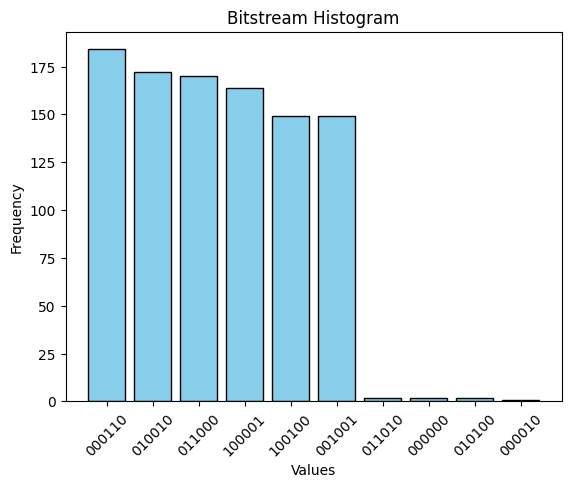

In [12]:
sorted_histo_list1=histo_dict_to_slist(res)
plot_beautiful_histogram(sorted_histo_list1[0:10])

Vediamo che soluzioni sono state scelte da Grover. Facciamo un poco di postprocessing

In [13]:
for i in range(6):
    print(color_histo(sorted_histo_list1[i]) )

color_list=[color_histo(sorted_histo_list1[i]) for i in range(6)]


['red', 'green', 'blue']
['green', 'red', 'blue']
['green', 'blue', 'red']
['blue', 'red', 'green']
['blue', 'green', 'red']
['red', 'blue', 'green']


Plottiamo ora le soluzioni nel grafico. Vediamo che sono state identificate correttamente le sei combinazioni a colori alternati

Graph with 3 nodes and 3 edges


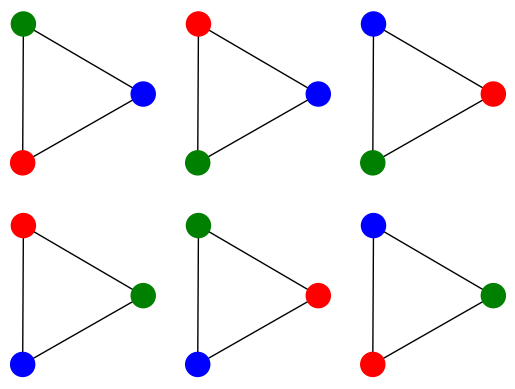

In [14]:
G=nx.Graph()
G.add_nodes_from(vertices)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
print(G)
fig, axes=plt.subplots(nrows=2, ncols=3)
axes=axes.flatten()
for i in range(6):
    nx.draw(G, pos, node_color=color_list[i], ax=axes[i])
plt.show()

Ora proviamo a risolvere il problema del MaxCUT su un grafico più grande. Nella teoria dei grafi, un taglio è una partizione dei vertici di un grafo in due sottoinsiemi disgiunti. Il problema del MaxCut trova il taglio massimo, la colorazione dei vertici con due colori tale che il numero massimo di lati viene "tagliato". Un lato viene "tagliato" se i vertici ai suoi estremi sono colorati con colore diverso. Se il numero di lati tagliati è uguale al numero di lati del grafo, allora il grafo è bipartito.

In [16]:

import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon
from time import time
import utm

%matplotlib inline
place_name='Cagliari, Italy' #district of school
graph=ox.graph_from_bbox((9.06, 39.18,9.18, 39.26), network_type='drive')
type(graph)
nodes_map, edges_map = ox.graph_to_gdfs(graph)  
df2=pd.read_csv('elenco_punti_cagliari_10.csv')  #csv file with the data
print(df2.index)
geometry2=[Point(xy) for xy in zip( df2["lon"], df2["lat"])]

RangeIndex(start=0, stop=10, step=1)


510827.48284747906 4341827.407014567
508543.023066123 4342316.199730042
509365.6375267231 4340813.42321321
509658.50528842665 4342733.656952111
509381.11731709266 4341582.501803358
510715.3939224732 4339847.450180765
509848.6909315411 4341800.588749855
509812.33057778794 4342574.043424858
510486.9867784521 4341489.577176996
508870.7659404959 4341765.01594662
[array([1076.48942782,  152.42059533]), array([-1207.97035354,   641.2133108 ]), array([-385.35589294, -861.56320603]), array([ -92.48813123, 1058.67053287]), array([-369.87610257,  -92.48461588]), array([  964.40050281, -1827.53623847]), array([ 97.69751188, 125.60233062]), array([ 61.33715813, 899.05700562]), array([ 735.99335879, -185.40924224]), array([-880.22747916,   90.02952738])]


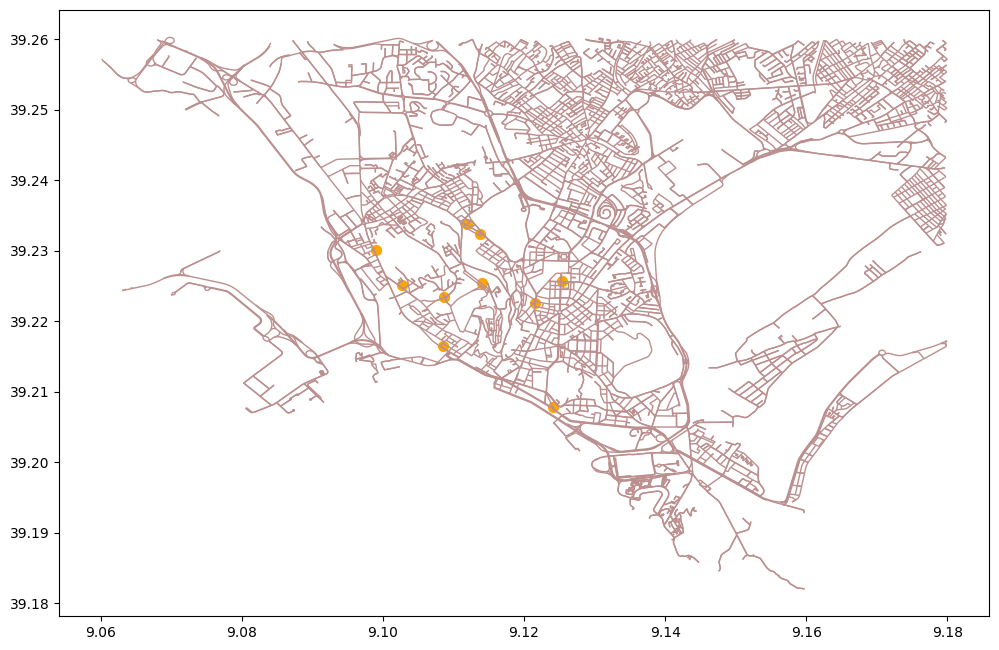

In [17]:
geo_df2=gpd.GeoDataFrame(df2, geometry=geometry2)  
fig, ax = plt.subplots(figsize=(12,12)) 
edges_map.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')  
geo_df2.plot(ax=ax, marker='o', markersize=50, color="orange")
geo_df2_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df2.geometry]
geo_coor_list0=[utm.from_latlon(point.xy[1][0], point.xy[0][0])[0:2] for point in geo_df2.geometry]
geo_coor_list=[]
umean=0
vmean=0
for point in geo_coor_list0:
    u,v= point
    print(u,v)
    umean+=u
    vmean+=v
    geo_coor_list.append(np.array((u,v)))

umean=umean/10
vmean=vmean/10
for arr in geo_coor_list:
    arr[0]=arr[0]-umean
    arr[1]=arr[1]-vmean
print(geo_coor_list)

13


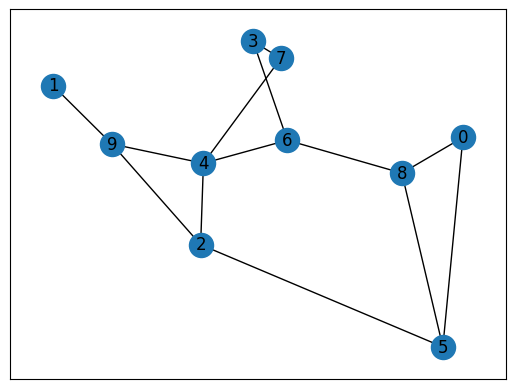

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
# setup Erdos Renyi graph
n = 10 # number of nodes/vertices
m = 15  # number of edges

vertices = list(range(n))
edges = [[0,1], [1,2], [0,2]]

seed=2030
G=nx.Graph()
G.add_nodes_from(vertices)
# define graph object

# positions for all nodes
pos = nx.spring_layout(G)
for i in range(n):
    pos[i] = geo_coor_list[i]

edges=[[1,9],[9,4],[9,2],[3,7],[4,7], [2,5], [6,3],[0,8], [0,5],[8,5], [6,4],[4,2], [6,8] ]
list_edges=edges
m=len(edges)
print(m)
weights=[1]*m
G.add_edges_from(edges)
# draw graph
nx.draw_networkx(G, pos)
plt.show()



Proviamo con un metodo "brute force" su computer convenzionale per sapere se il grafo può essere bipartito, ovvero se il numero massimo di tagli che posso trovare è pari al numero di lati.

In [19]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def count_cuts(sl1):
    colrs=[]
    cuts=0

    for k in range(len(sl1)):
        if  sl1[k] == 0:
            colrs.append(0)
        else:
            colrs.append(1)
    
    for u,v in list_edges:
        if colrs[u] != colrs[v]:
            cuts+=1

    print("Number of cuts:", cuts )
    return cuts

case = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 2.0
case = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 1.0
case = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 5.0
case = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0] cost = 4.0
case = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0] cost = 6.0
case = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] cost = 2.0
case = [1, 0, 0, 1, 0, 0, 0, 0, 0, 0] cost = 4.0
case = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 5.0
case = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0] cost = 5.0
case = [1, 0, 1, 1, 0, 0, 0, 0, 0, 0] cost = 7.0
case = [0, 1, 1, 1, 0, 0, 0, 0, 0, 0] cost = 6.0
case = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0] cost = 8.0
case = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] cost = 4.0
case = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0] cost = 6.0
case = [0, 1, 0, 0, 1, 0, 0, 0, 0, 0] cost = 5.0
case = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0] cost = 7.0
case = [0, 0, 1, 0, 

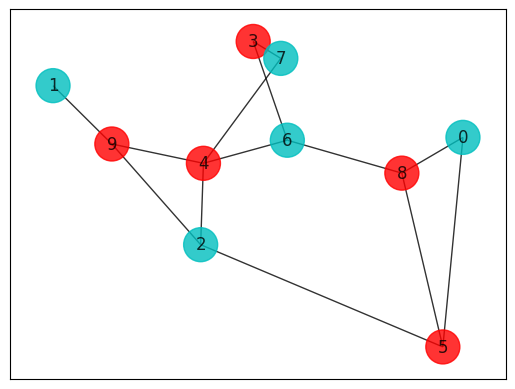

In [20]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = 1
            
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

In [21]:
cuts_best_brute=count_cuts(xbest_brute)

Number of cuts: 11


Definiamo ora il problema del maxcut facendo l'oracolo che seleziona le soluzioni come spiegato nella presentazione.

Sappiamo che il numero di tagli è al più pari al numero di lati.  con un numero di lati uguali a 20 sappiamo che il numero di tagli sarà codificato in cinque cifre binarie-

In [22]:
n_cuts=math.ceil(np.log2(m))
print("Il buffer per i tagli è costituito da ",n_cuts," bit")


Il buffer per i tagli è costituito da  4  bit


In [23]:
qubit_vertices= list(range(n))
qubit_edges= list(range (n,n+m))
qubit_cuts=list(range(n+m, n+m+n_cuts))
print("I qubit che rappresentano i vertici sono",  qubit_vertices)
print("I qubit che rappresentano i lati sono",qubit_edges)
print("I qubit che rappresentano i tagli sono",qubit_cuts)
qubit_ancilla=n+m+n_cuts
qubit_ancilla2=n+m+n_cuts+1
qubit_ancilla3=n+m+n_cuts+2
qubit_ancilla4=n+m+n_cuts+3

I qubit che rappresentano i vertici sono [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
I qubit che rappresentano i lati sono [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
I qubit che rappresentano i tagli sono [23, 24, 25, 26]


In [24]:
def edge_check(a,b,c):
    circ=Circuit()
    circ.push(GateCX(),a,c)
    circ.push(GateCX(),b,c)
    return circ

def oracle_edges_1(qe_buf):
    circ2=Circuit()
    n_edges=len(qe_buf)
    for i in range(n_edges):
        istart, iend =list_edges[i]
        circ2.append(edge_check(istart, iend, qe_buf[i]))
    return circ2

def oracle_inv_edges_1(qe_buf):
    circ2=Circuit()
    n_edges=len(qe_buf)
    for i in range(n_edges-1,-1,-1):
        istart, iend =list_edges[i]
        circ2.append(edge_check(istart, iend, qe_buf[i]))
    return circ2
   

In [25]:
def oracle_cuts(n_edges, list_qe, n_cuts, list_qc):
    circc=Circuit()
    for i in range(n_edges):
        if i==0:
            circc.push(GateCX(),list_qe[i],list_qc[0])
        elif i< 3:
            list1=[list_qe[i], list_qc[0]]
            circc.push(Control(2, GateX()),*list1 , list_qc[1])
            circc.push(GateCX(),list_qe[i],list_qc[0])
        elif i< 7:
            list2=[list_qe[i], list_qc[0],list_qc[1]]
            list1=[list_qe[i], list_qc[0]]
            circc.push(Control(3, GateX()),*list2, list_qc[2])
            circc.push(Control(2, GateX()),*list1 , list_qc[1])
            circc.push(GateCX(),list_qe[i],list_qc[0])
        elif i< 15:
            list3=[list_qe[i], list_qc[0],list_qc[1],list_qc[2]]
            list2=[list_qe[i], list_qc[0],list_qc[1]]
            list1=[list_qe[i], list_qc[0]]
            circc.push(Control(4, GateX()),*list3, list_qc[3])
            circc.push(Control(3, GateX()),*list2, list_qc[2])
            circc.push(Control(2, GateX()),*list1 , list_qc[1])
            circc.push(GateCX(),list_qe[i],list_qc[0])
        elif i< 31:
            list4=[list_qe[i], list_qc[0],list_qc[1],list_qc[2], list_qc[3] ]
            list3=[list_qe[i], list_qc[0],list_qc[1], list_qc[2]]
            list2=[list_qe[i], list_qc[0],list_qc[1]]
            list1=[list_qe[i], list_qc[0]]
            circc.push(Control(5, GateX()),*list4, list_qc[4])
            circc.push(Control(4, GateX()),*list3, list_qc[3])
            circc.push(Control(3, GateX()),*list2, list_qc[2])
            circc.push(Control(2, GateX()),*list1 , list_qc[1])
            circc.push(GateCX(),list_qe[i],list_qc[0])

    return circc


def oracle_cuts_inv(n_edges, list_qe, n_cuts, list_qc):
    circc=Circuit()
    for i in range(n_edges-1,-1,-1):
        if i==0:
            circc.push(GateCX(),list_qe[i],list_qc[0])
        elif i< 3:
            list1=[list_qe[i], list_qc[0]]
           
            circc.push(GateCX(),list_qe[i],list_qc[0])
            circc.push(Control(2, GateX()),*list1 , list_qc[1])
        elif i< 7:
            list2=[list_qe[i], list_qc[0],list_qc[1]]
            list1=[list_qe[i], list_qc[0]]
            circc.push(GateCX(),list_qe[i],list_qc[0])   
            circc.push(Control(2, GateX()),*list1 , list_qc[1])
            circc.push(Control(3, GateX()),*list2, list_qc[2])
        elif i< 15:
            list3=[list_qe[i], list_qc[0],list_qc[1] ,list_qc[2]]
            list2=[list_qe[i], list_qc[0],list_qc[1]]
            list1=[list_qe[i], list_qc[0]]
            circc.push(GateCX(),list_qe[i],list_qc[0])
            circc.push(Control(2, GateX()),*list1 , list_qc[1])
            circc.push(Control(3, GateX()),*list2, list_qc[2])
            circc.push(Control(4, GateX()),*list3, list_qc[3])
            
        elif i< 31:
            list4=[list_qe[i], list_qc[0],list_qc[1],list_qc[2], list_qc[3] ]
            list3=[list_qe[i], list_qc[0],list_qc[1], list_qc[2]]
            list2=[list_qe[i], list_qc[0],list_qc[1]]
            list1=[list_qe[i], list_qc[0]]
            circc.push(GateCX(),list_qe[i],list_qc[0])
            circc.push(Control(2, GateX()),*list1 , list_qc[1])
            circc.push(Control(3, GateX()),*list2, list_qc[2])
            circc.push(Control(4, GateX()),*list3, list_qc[3])
            circc.push(Control(5, GateX()),*list4, list_qc[4])

    return circc


def oracle_check_cuts(n_cuts, list_qc, anc, max_cuts):
    circc=Circuit()
    mstring=max_cuts[::-1]
    for i in range(len(mstring)):
        if mstring[i]=="0":
            circc.push(GateX(),list_qc[i])
    return circc
    

In [26]:
ancilla=n+m+n_cuts
def circ_coloring_maxcut(ancilla, max_cuts, niter):
    circ=Circuit()
    circ.push(GateH(),range(0,n))
    for i in range(niter):
        circ.push(GateX(),ancilla+i)
        circ.append(oracle_edges_1(qubit_edges))
        circ.append(oracle_cuts(m, qubit_edges, n_cuts, qubit_cuts))
        circ.append(oracle_check_cuts(n_cuts, qubit_cuts, ancilla+i, max_cuts))
        circ.push(Control(n_cuts,GateX()), *qubit_cuts, ancilla+i)
        circ.push(GateZ(),ancilla+i)
        circ.push(Control(n_cuts,GateX()), *qubit_cuts, ancilla+i)
        circ.append(oracle_check_cuts(n_cuts, qubit_cuts, ancilla+i, max_cuts))
        circ.append(oracle_cuts_inv(m, qubit_edges, n_cuts, qubit_cuts))
        circ.append(oracle_inv_edges_1(qubit_edges))
        circ.append(grover_diffusion(n))
    circ.push(Measure(), range(0,n), range(0,n))
    return circ

In [27]:
def grover_diffusion(n_bits):
    circd=Circuit()
    circd.push(GateH(),range(0,n_bits))
    circd.push(GateX(),range(0,n_bits))
    circd.push(Control(n_bits-1, GateZ()),*range(n_bits-1) ,n_bits-1)
    circd.push(GateX(),range(0,n_bits))
    circd.push(GateH(),range(0,n_bits))
    return circd

Supponiamo di vedere se possiamo trovare la soluzione con numero di tagli uguale a 11

Per quante iterazioni di Grover dovremo iterare? se sapessimo che quattro combinazioni danno 11 tagli allora 

In [28]:
niter=math.floor((np.pi/4)*np.sqrt(2**n/4))
print(niter)

12


In [29]:
max_cuts=format(cuts_best_brute, '0%db'%n_cuts)
print(max_cuts)

1011


In [30]:
ancilla=n+m+n_cuts
circColoring4_NW=circ_coloring_maxcut(ancilla, max_cuts, 1)
job4_NW= conn.execute(circColoring4_NW, seed=1)

res4_NW= conn.get_results(job4_NW)[0]

In [31]:
circColoring4_NW_2=circ_coloring_maxcut(ancilla, max_cuts, 2)
job4_NW_2= conn.execute(circColoring4_NW_2, seed=1)

res4_NW_2= conn.get_results(job4_NW_2)[0]

In [32]:
circColoring4_NW_3=circ_coloring_maxcut(ancilla, max_cuts, 3)
job4_NW_3= conn.execute(circColoring4_NW_3, seed=3)

res4_NW_3= conn.get_results(job4_NW_3)[0]

In [33]:
circColoring4_NW_4=circ_coloring_maxcut(ancilla, max_cuts, 4)
job4_NW_4= conn.execute(circColoring4_NW_4, seed=3)

res4_NW_4= conn.get_results(job4_NW_4)[0]

In [35]:
circColoring4_NW_5=circ_coloring_maxcut(ancilla, max_cuts, 5)
job4_NW_5= conn.execute(circColoring4_NW_5, seed=3)

res4_NW_5= conn.get_results(job4_NW_5)[0]

In [36]:
circColoring4_NW_6=circ_coloring_maxcut(ancilla, max_cuts, 6)
job4_NW_6= conn.execute(circColoring4_NW_6, seed=3)

res4_NW_6= conn.get_results(job4_NW_6)[0]

In [37]:
circColoring4_NW_7=circ_coloring_maxcut(ancilla, max_cuts, 7)
job4_NW_7= conn.execute(circColoring4_NW_7, seed=3)

res4_NW_7= conn.get_results(job4_NW_7)[0]

Ora visualizziamo i risultati dei run dei sette circuiti che corrispondono ai con numero di iterazioni di Grover pari a 1,2,3,4,5,6,7. Dai grafici qui sotto si può notare che il numero ottimale di iterazioni per l'algoritmo di Grover è 6 perché presenta il picco più alto nell'istogramma a contrassegnare il bitstream che è soluzione del problema

[('0000011101', 11), ('0001110011', 9), ('0101110010', 9), ('1000011101', 8), ('0111100010', 7), ('1010001101', 7), ('1110001100', 6), ('0000110000', 5), ('1100000001', 4), ('1101000110', 4)]
[('0111100010', 29), ('0001110011', 28), ('1010001101', 27), ('0000011101', 26), ('1110001100', 25), ('1000011101', 25), ('1111100010', 22), ('0101110010', 16), ('0000100011', 5), ('1101111010', 4)]
[('0111010100', 12), ('0101111000', 10), ('1000001000', 10), ('0001000001', 10), ('0010001100', 9), ('0010010000', 9), ('0100001000', 9), ('1001111000', 9), ('1001111001', 8), ('0111111101', 8)]
[('0000011000', 13), ('0101111000', 12), ('1000001000', 10), ('0010011000', 9), ('1100001100', 9), ('1011001000', 9), ('0010001100', 8), ('0010010001', 8), ('0000111100', 8), ('0001100100', 8)]
[('1001000000', 12), ('0000000000', 10), ('1000011101', 10), ('1011010100', 10), ('0110000000', 9), ('0110011101', 9), ('1010011101', 9), ('1011001000', 9), ('0000011000', 8), ('0011001000', 8)]
[('1000011101', 27), ('10

(0.0, 1.0, 0.0, 1.0)

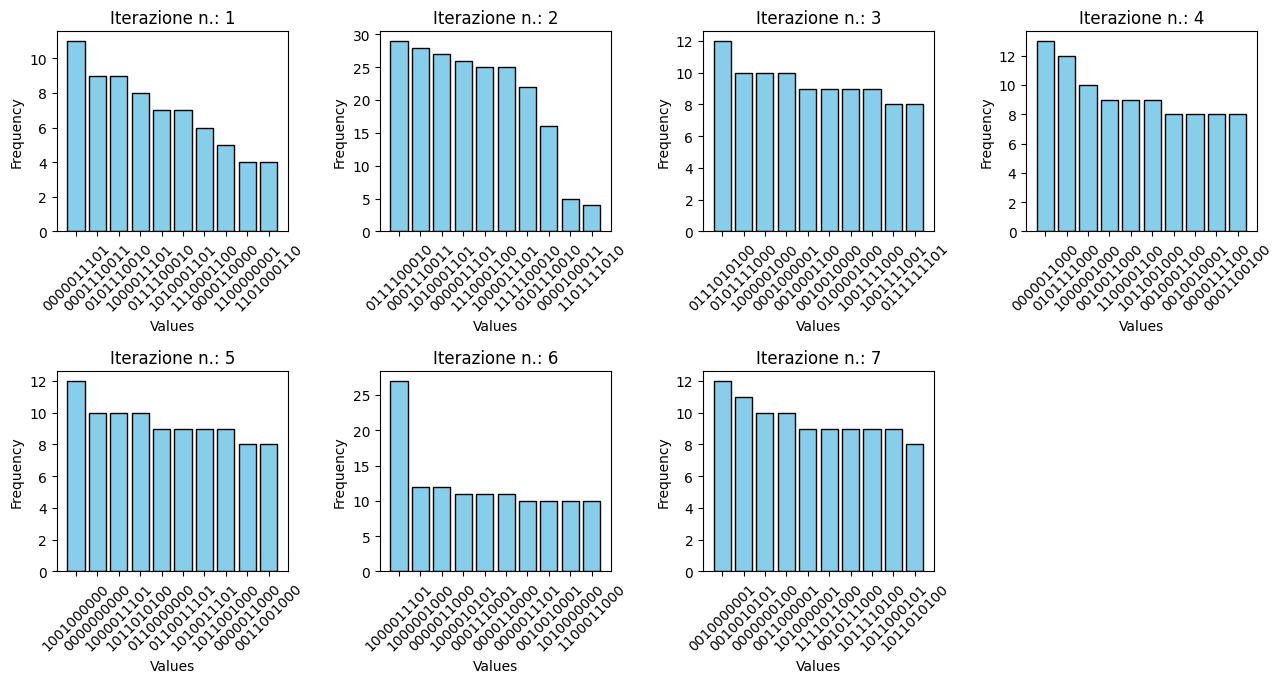

In [38]:
sorted_histo_res4_NW=histo_dict_to_slist(res4_NW)
sorted_histo_res4_NW_2=histo_dict_to_slist(res4_NW_2)
sorted_histo_res4_NW_3=histo_dict_to_slist(res4_NW_3)
sorted_histo_res4_NW_4=histo_dict_to_slist(res4_NW_4)
sorted_histo_res4_NW_5=histo_dict_to_slist(res4_NW_5)
sorted_histo_res4_NW_6=histo_dict_to_slist(res4_NW_6)
sorted_histo_res4_NW_7=histo_dict_to_slist(res4_NW_7)


sorted_histo_grov=[sorted_histo_res4_NW, sorted_histo_res4_NW_2, sorted_histo_res4_NW_3,
                   sorted_histo_res4_NW_4, sorted_histo_res4_NW_5, sorted_histo_res4_NW_6, sorted_histo_res4_NW_7 ]

fig, axes=plt.subplots(nrows=2, ncols=4, figsize=(15, 9))
plt.subplots_adjust(left=0.1,
                    bottom=0.3, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.7)
axes=axes.flatten()
for i in range(7):
    myh=sorted_histo_grov[i]
    print(myh[0:10])
    plot_beautiful_histogram(myh[0:10], ax=axes[i], title="Iterazione n.: %d"%(i+1))
axes[7].axis('off')

In [39]:
def plot_bgraph(mytuple, ax):
    s1, nocc=mytuple
    color_map = []
    for node in G:
        if s1[node] == '0':
            color_map.append('blue')
        else: 
            color_map.append('green')      
    nx.draw(G, pos, node_color=color_map, with_labels=True, ax=ax)

Contiamo i tagli della soluzione trovata

In [40]:
def count_number_of_cuts(histo_tuple):
    s1,count=histo_tuple
    print(s1)
    colrs=[]
    cuts=0
    for k in range(len(s1)):
        if  s1[k] == '0':
            colrs.append(0)
        else:
            colrs.append(1)
    for u,v in list_edges:
        if colrs[u] != colrs[v]:
            cuts+=1
    print(cuts)
    return cuts
    
cuts_list=[]
for i in range(7):
    cuts= count_number_of_cuts(sorted_histo_grov[i][0])
    print ("Iterazione",i+1, "Numero di tagli trovati", cuts)
    cuts_list+=[cuts]



0000011101
11
Iterazione 1 Numero di tagli trovati 11
0111100010
11
Iterazione 2 Numero di tagli trovati 11
0111010100
7
Iterazione 3 Numero di tagli trovati 7
0000011000
6
Iterazione 4 Numero di tagli trovati 6
1001000000
4
Iterazione 5 Numero di tagli trovati 4
1000011101
11
Iterazione 6 Numero di tagli trovati 11
0010000001
4
Iterazione 7 Numero di tagli trovati 4


('0000011101', 11)
('0111100010', 29)
('0111010100', 12)
('0000011000', 13)
('1001000000', 12)
('1000011101', 27)
('0010000001', 12)


(0.0, 1.0, 0.0, 1.0)

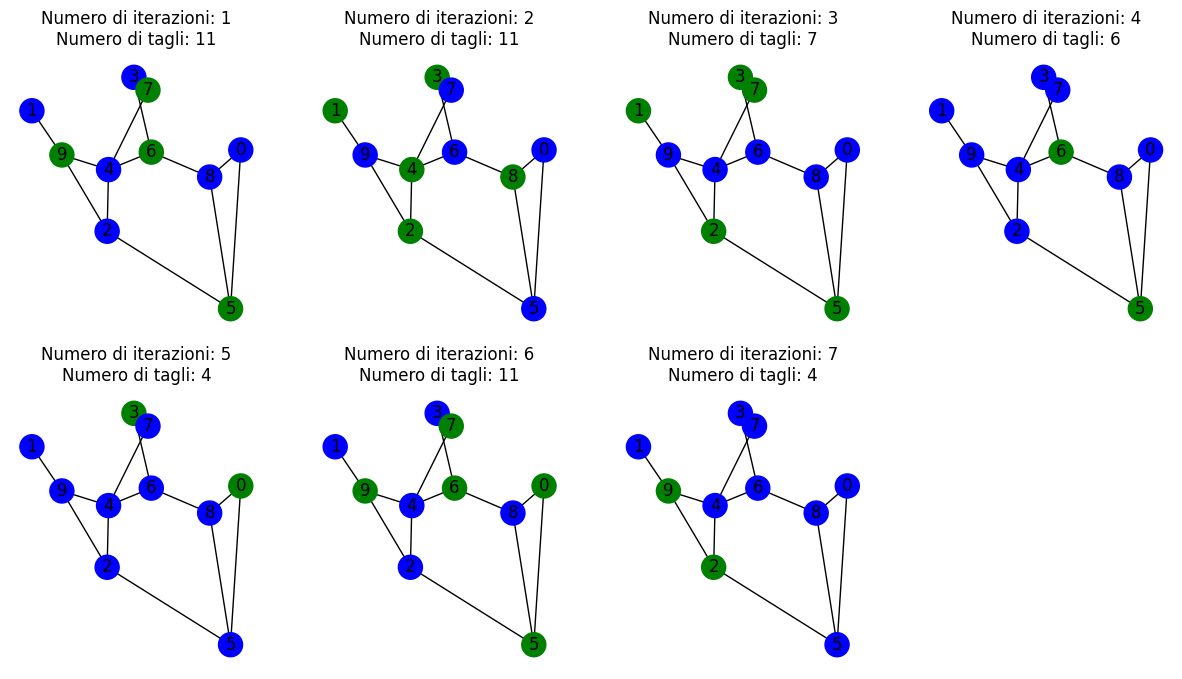

In [41]:
fig, axes=plt.subplots(nrows=2, ncols=4, figsize=(15,8))
axes=axes.flatten()
for i in range(7):
    myh=sorted_histo_grov[i][0]
    print(myh[0:10])
    plot_bgraph(myh[0:10], axes[i])
    axes[i].title.set_text('Numero di iterazioni: '+str(i+1)+'\nNumero di tagli: '+str(cuts_list[i]))
axes[7].axis('off')   

Come volevasi dimostrare l'algoritmo di Grover ha trovato dopo qualche iterazione la soluzione con il numero di tagli desiderato. Operativamente se non si conosce il numero di tagli massimo del grafo, si parte dal numero massimo di lati decrementandoli ogni volta e si cerca con Grover un istogramma che mostri la dominanza di uno o più bitstream.
